# Wind Power Prediction Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import math
from itertools import islice


# Column formats
headers = ["Year", "Month", "Day", "Hour", "Minute",
           "Power", "Wind Direction", "Wind Speed",
           "Temperature", "Pressure", "Height"]

data = pd.read_csv("test_data_single_site.csv", sep=',', skiprows=4, names=headers)

### Construct transition matrix based on required resolution

In [2]:
req_resolution = 0.1 # in (MW)

max_wind_power = data['Power'].max()
min_wind_power = data['Power'].min()

# Discretise wind power
n_bins = int(math.ceil((max_wind_power - min_wind_power) / req_resolution))

print("Max Wind Power: ", max_wind_power)
print("Min Wind Power: ", min_wind_power)

# Construct transition matrix
transition_mtx = [[0.0 for i in range(n_bins + 1)] for j in range(n_bins + 1)]
#print(transition_mtx)

bin_size = (max_wind_power - min_wind_power) / n_bins

('Max Wind Power: ', 16.0)
('Min Wind Power: ', 0.0)


### Populate first order transition matrix

In [3]:

# Initial assumption
init_power = data['Power'][0]

prev_power_val = init_power
latest_power_val = None

for index, row in data.iterrows():

    prev_power_idx = int(prev_power_val / bin_size)
    prev_power_val = row['Power']
    curr_power_idx = int(prev_power_val / bin_size)

    # Update transition matrix
    transition_mtx[prev_power_idx][curr_power_idx] += 1

    prev_power_val = row['Power']
    
num_data_points = data['Power'].count()

raw_transition_mtx = transition_mtx

In [4]:
# Normalise each row of transition matrix 

for index, row in enumerate(transition_mtx):
    norm_sum = 0
    for elem in transition_mtx[index]:
        norm_sum += elem
    transition_mtx[index] = [x / norm_sum for x in transition_mtx[index]]

### Benchmark for Markov Chain Order
#### - Checking for independence of state transition events
#### P( State S[t+1] reached from State S[t] | State S[i] was before State S[t])
#### = P( State S[t+1] reached from State S[t]) # To guarantee first-order independence

In [5]:
# Construct a second order transition matrix
second_order_transition_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**2)]

# Initial assumption
first_power_state = init_power
second_power_state = data['Power'][1]

for index, row in data.iterrows():

    prev_power_first_idx = int(first_power_state / bin_size)
    prev_power_second_idx = int(second_power_state / bin_size)
    
    first_power_state = second_power_state
    second_power_state = row['Power']
    
    curr_power_idx = int(second_power_state / bin_size)

    # Update transition matrix
    #print(prev_power_first_idx * n_bins + prev_power_second_idx)
    second_order_transition_mtx[prev_power_first_idx * n_bins + prev_power_second_idx][curr_power_idx] += 1

    latest_power_val = row['Power']
    
num_data_points = data['Power'].count()


#### Error Factor == {P(E1) - P(E1.E2)/P(E2)}

In [7]:
# Error factor calculation

first_order_error_factor = 0

for curr_state_idx, next_states in enumerate(transition_mtx):
    
    max_state_idx = 0
    max_probability = 0
    has_next_state = False
    for state_idx, state_probability in enumerate(next_states):
        if state_probability > max_probability:
            max_probability = state_probability
            max_state_idx = state_idx
            has_next_state = True
    
    if has_next_state:
        
        for i in range(0, n_bins + 1):
            # print((n_bins + 1) * i + curr_state_idx)
            row_sum = sum(second_order_transition_mtx[(n_bins + 1) * i + curr_state_idx])
            if row_sum != 0:
                second_order_state_probability = second_order_transition_mtx[(n_bins + 1) * i + curr_state_idx][max_state_idx]
                if second_order_state_probability != 0:
                    col_totals = [ sum(x) for x in zip(*raw_transition_mtx) ]
                    back_probability = raw_transition_mtx[i][curr_state_idx]/col_totals[curr_state_idx]
                    if back_probability != 0:
                        first_order_error_factor += (max_probability - second_order_state_probability/back_probability)**2
                    
print("Error Factor: ", first_order_error_factor)                    

('Error Factor: ', 305716607.5571029)


### Heatmap for Second Order Markov Chain

Text(0.5,1,'Second-Order Markov Chain')

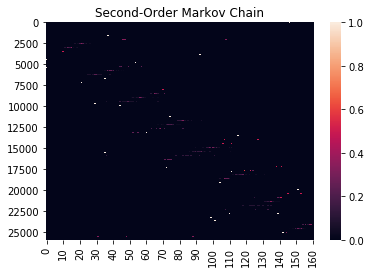

In [8]:
# Normalise each row of transition matrix 

for index, row in enumerate(second_order_transition_mtx):
    sum = 0
    for elem in second_order_transition_mtx[index]:
        sum += elem
    if sum != 0:    
        second_order_transition_mtx[index] = [x / sum for x in second_order_transition_mtx[index]]

# # Plot heatmap    

# y, x = np.meshgrid(np.linspace(min_wind_power, max_wind_power, (n_bins + 1)**2), np.linspace(min_wind_power, max_wind_power, n_bins))

# z = np.array(second_order_transition_mtx)
# #print(z)
# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
# z_min, z_max = np.abs(z).min(), np.abs(z).max() # Tweak parameter for

# fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# ax.set_title('1st Order Markov Chain Heatmap')
# # set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
# fig.colorbar(c, ax=ax)

# plt.show()

# # Heatmap alternative plot
# plt.imshow(second_order_transition_mtx, cmap='hot', interpolation='nearest')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.axis('tight')
# plt.show()
# plt.axes.Axes.set_xscale(1, 'linear')

ax = seaborn.heatmap(second_order_transition_mtx, xticklabels=10, yticklabels=2500)
ax.set_title('Second-Order Markov Chain')

# numpy_transition_mtx = np.array(second_order_transition_mtx)

# num_plots = 0
# for index in range(len(second_order_transition_mtx)):
#     plt.plot(numpy_transition_mtx[index,:])
#     num_plots += 1
#     if num_plots == 50:
#         break
# plt.title("Probability Distributions of Bins")
# plt.show()

In [ ]:
# # Construct a third order transition matrix
third_order_transition_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**3)]

# Initial assumption
first_power_state = init_power
second_power_state = data['Power'][1]
third_power_state = data['Power'][2]

for index, row in islice(df.iterrows(), 3, None)

    prev_power_first_idx = int(first_power_state / bin_size)
    prev_power_second_idx = int(second_power_state / bin_size)
    prev_power_third_idx = int(third_power_state / bin_size)
    
    first_power_state = second_power_state
    second_power_state = row['Power']
    
    curr_power_idx = int(second_power_state / bin_size)

    # Update transition matrix
    #print(prev_power_first_idx * n_bins + prev_power_second_idx)
    second_order_transition_mtx[prev_power_first_idx * n_bins + prev_power_second_idx][curr_power_idx] += 1

    latest_power_val = row['Power']
    
num_data_points = data['Power'].count()

In [1]:
# Generates a kernel matrix based on global input CSV file
# Input: Order of Markov Chain
# Output: 2D-list (Matrix)
def construct_markov_kernel(order, normalised=True):
    
    kernel_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**order)]
    
    power_state = []
    
    # Initial assumption
    for i in range(order):
        power_state.append(data['Power'][i])
        
    for idx, row in islice(df.iterrows(), order, None): # Skip initial rows based on order
        
        prev_idx = [-1 for _ in range(order)]
        for j, elem in enumerate(prev_idx):
            elem = int(power_state[j] / bin_size)
        
        # Update power states
        for i in range(order - 1):
            power_state[i] = power_state[i + 1]
        power_state[order - 1] = row['Power']
        
        curr_power_idx = int(power_state[order - 1])
        
        # Update transition matrix
            kernel_prev_idx = 0
            for i in range(order - 1):
                kernel_prev_idx += prev_idx[i] * n_bins * (order - i - 1)
            kernel_prev_idx += prev_idx[order - 1]    
            kernel_mtx[kernel_prev_idx][curr_power_idx] += 1
            
        if normalised:
    
            for index, row in enumerate(kernel_mtx):
                norm_sum = 0
                for elem in kernel_mtx[index]:
                    norm_sum += elem
                        kernel_mtx[index] = [x / norm_sum for x in kernel_mtx[index]]            
            
    return kernel_mtx         

IndentationError: unexpected indent (<ipython-input-1-b901833fded5>, line 28)

In [13]:
# Sanity check

for index, row in enumerate(transition_mtx):
    sanity_check = 0
    for idx, col in enumerate(transition_mtx[index]):
        sanity_check += transition_mtx[index][idx]
    print("Row: ", index, " Sum: ", sanity_check)

#print("Sanity Check: ", sanity_check)

('Row: ', 0, ' Sum: ', 1.0000000000000004)
('Row: ', 1, ' Sum: ', 1.0000000000000002)
('Row: ', 2, ' Sum: ', 0.9999999999999999)
('Row: ', 3, ' Sum: ', 1.0000000000000004)
('Row: ', 4, ' Sum: ', 1.0)
('Row: ', 5, ' Sum: ', 0.9999999999999998)
('Row: ', 6, ' Sum: ', 0.9999999999999999)
('Row: ', 7, ' Sum: ', 0.9999999999999998)
('Row: ', 8, ' Sum: ', 1.0000000000000002)
('Row: ', 9, ' Sum: ', 0.9999999999999999)
('Row: ', 10, ' Sum: ', 1.0)
('Row: ', 11, ' Sum: ', 0.9999999999999998)
('Row: ', 12, ' Sum: ', 1.0000000000000002)
('Row: ', 13, ' Sum: ', 1.0)
('Row: ', 14, ' Sum: ', 0.9999999999999998)
('Row: ', 15, ' Sum: ', 0.9999999999999998)
('Row: ', 16, ' Sum: ', 0.9999999999999999)
('Row: ', 17, ' Sum: ', 1.0000000000000002)
('Row: ', 18, ' Sum: ', 0.9999999999999999)
('Row: ', 19, ' Sum: ', 1.0)
('Row: ', 20, ' Sum: ', 0.9999999999999998)
('Row: ', 21, ' Sum: ', 0.9999999999999997)
('Row: ', 22, ' Sum: ', 1.0)
('Row: ', 23, ' Sum: ', 1.0000000000000002)
('Row: ', 24, ' Sum: ', 0.999

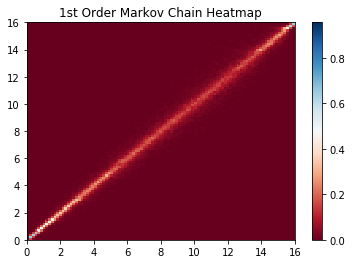

In [30]:
# Heatmap plot

y, x = np.meshgrid(np.linspace(min_wind_power, max_wind_power, n_bins), np.linspace(min_wind_power, max_wind_power, n_bins))

z = np.array(transition_mtx)
#print(z)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max() # Tweak parameter for

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('1st Order Markov Chain Heatmap')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

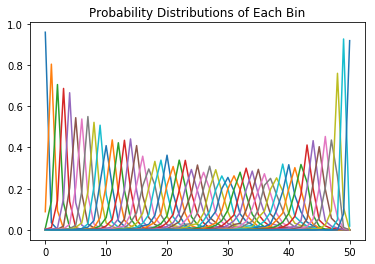

In [53]:
numpy_transition_mtx = np.array(transition_mtx)

num_plots = 0
for index in range(len(transition_mtx)):
    plt.plot(numpy_transition_mtx[index,:])
    num_plots += 1
#     if num_plots == 25:
#         break
plt.title("Probability Distributions of Bins")
plt.show()

In [55]:
# Sanity check

for index, row in enumerate(transition_mtx):
    sanity_check = 0
    for idx, col in enumerate(transition_mtx[index]):
        sanity_check += transition_mtx[index][idx]
    print("Row: ", index, " Sum: ", sanity_check)

#print("Sanity Check: ", sanity_check)

('Row: ', 0, ' Sum: ', 1.0000000000000004)
('Row: ', 1, ' Sum: ', 1.0000000000000002)
('Row: ', 2, ' Sum: ', 0.9999999999999999)
('Row: ', 3, ' Sum: ', 1.0000000000000004)
('Row: ', 4, ' Sum: ', 1.0)
('Row: ', 5, ' Sum: ', 0.9999999999999998)
('Row: ', 6, ' Sum: ', 0.9999999999999999)
('Row: ', 7, ' Sum: ', 0.9999999999999998)
('Row: ', 8, ' Sum: ', 1.0000000000000002)
('Row: ', 9, ' Sum: ', 0.9999999999999999)
('Row: ', 10, ' Sum: ', 1.0)
('Row: ', 11, ' Sum: ', 0.9999999999999998)
('Row: ', 12, ' Sum: ', 1.0000000000000002)
('Row: ', 13, ' Sum: ', 1.0)
('Row: ', 14, ' Sum: ', 0.9999999999999998)
('Row: ', 15, ' Sum: ', 0.9999999999999998)
('Row: ', 16, ' Sum: ', 0.9999999999999999)
('Row: ', 17, ' Sum: ', 1.0000000000000002)
('Row: ', 18, ' Sum: ', 0.9999999999999999)
('Row: ', 19, ' Sum: ', 1.0)
('Row: ', 20, ' Sum: ', 0.9999999999999998)
('Row: ', 21, ' Sum: ', 0.9999999999999997)
('Row: ', 22, ' Sum: ', 1.0)
('Row: ', 23, ' Sum: ', 1.0000000000000002)
('Row: ', 24, ' Sum: ', 0.999

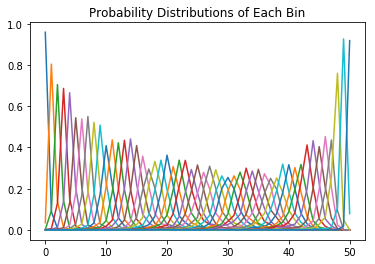

In [54]:
num_plots = 0
for index in range(len(transition_mtx)):
    plt.plot(numpy_transition_mtx[:,index])
    num_plots += 1
#     if num_plots == 25:
#         break
plt.title("Probability Distributions of Each Bin")
plt.show()

In [56]:
for col_idx in range(len(transition_mtx[0])):
    col_sum = 0
    for row_idx, row in enumerate(transition_mtx):
        col_sum += transition_mtx[row_idx][col_idx]
        
    print("Column: ", col_idx, " Sum: ", col_sum)

('Column: ', 0, ' Sum: ', 1.0723892207583376)
('Column: ', 1, ' Sum: ', 0.9999010213125894)
('Column: ', 2, ' Sum: ', 0.9640739706292293)
('Column: ', 3, ' Sum: ', 1.0094299556675328)
('Column: ', 4, ' Sum: ', 1.0679098978192831)
('Column: ', 5, ' Sum: ', 0.9455885144876647)
('Column: ', 6, ' Sum: ', 0.9835930546892393)
('Column: ', 7, ' Sum: ', 0.9985960236373834)
('Column: ', 8, ' Sum: ', 1.0328661650609865)
('Column: ', 9, ' Sum: ', 1.0399622346992377)
('Column: ', 10, ' Sum: ', 0.9506185791973009)
('Column: ', 11, ' Sum: ', 0.9942761086092783)
('Column: ', 12, ' Sum: ', 0.9728947053078884)
('Column: ', 13, ' Sum: ', 1.0007609123170578)
('Column: ', 14, ' Sum: ', 1.0986310469319918)
('Column: ', 15, ' Sum: ', 1.0464956600137147)
('Column: ', 16, ' Sum: ', 0.9622776232512171)
('Column: ', 17, ' Sum: ', 0.9179471019321651)
('Column: ', 18, ' Sum: ', 1.0153762811074474)
('Column: ', 19, ' Sum: ', 0.9921633182381709)
('Column: ', 20, ' Sum: ', 1.0275991666041822)
('Column: ', 21, ' Sum: